<a href="https://colab.research.google.com/github/BasseyIsrael/BasseyIsrael/blob/main/Hydrates%20Investigation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install shap

In [ ]:
pip install plotly

In [ ]:
import pandas as pd                              # For data frame manipulation and calculations
import numpy as np                               # For array manipulation
import os
%matplotlib inline
import matplotlib.pyplot as plt                  # To view figures
import seaborn as sns                            # For matrix plot visualization
import pandas.plotting as pd_plot       # used in function for visualization
from scipy import stats                   # summary statistics
from scipy import linalg                  # for linear regression
import random                             # for randon numbers

import warnings
warnings.filterwarnings("ignore")

from scipy import linalg, stats                  # for linear regression and  summary statistics
from timeit import default_timer as timer        # to measure the time of the runs
import csv # to create csv files
import shap
from tqdm import tqdm                            # progress meter that wraps around any iterable to determine % completion of program runnings.

# plotly imports – To generate interactive plots in notebook
from plotly.offline import init_notebook_mode,iplot                       # Figure generation
import plotly.figure_factory as ff

# import sklearn libraries for Modelling
from sklearn.decomposition import PCA   # for PCA
from sklearn.feature_selection import mutual_info_regression    #for Mutual Information
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler                            # standardize variables to mean of 0.0 and variance of 1.0
from sklearn.feature_selection import mutual_info_regression              # Bivariate relationship checker and feature importance check
from sklearn.model_selection import train_test_split, cross_validate      # For fair split of data into train and testing

In [ ]:
#The following code block is from Professor Michael Pyrcz (@GeostatsGuy), SubSurfuceDataAnalytics_PCA.ipynb from GeostatsGuy GitHub.

def partial_corr(C):
#    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
#    for the remaining variables in C.
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]
            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
    return P_corr

def plot_corr(dataframe,size=10):                         # plots a graphical correlation matrix 
    corr = dataframe.corr()
    fig, ax = plt.subplots(figsize=(size, size))
    im = ax.matshow(corr,vmin = -1.0, vmax = 1.0)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    plt.colorbar(im, orientation = 'vertical')
    plt.title('Correlation Matrix')
    
def visualize_tree(tree,xfeature,yfeature,response,title,):# plots the data points and the decision tree prediction 
    n_classes = 10
    cmap = plt.cm.RdYlBu
    plot_step = 0.02
    plt.figure(figsize=(8,6))
    x_min, x_max = min(xfeature) - 1, max(xfeature) + 1
    y_min, y_max = min(yfeature) - 1, max(yfeature) + 1
    resp_min = round(min(response)); resp_max = round(max(response));
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                     np.arange(y_min, y_max, plot_step))
    z_min = round(min(response)); z_max = round(max(response))
    Z = tree.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=cmap,vmin=z_min, vmax=z_max)

    im = plt.scatter(xfeature,yfeature,s=None, c=response, marker=None, cmap=cmap, norm=None, vmin=z_min, vmax=z_max, alpha=0.8, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title)
    plt.xlabel(xfeature.name)
    plt.ylabel(yfeature.name)
    cbar = plt.colorbar(im, orientation = 'vertical')
    cbar.set_label(response.name, rotation=270, labelpad=20)
    plt.show()
    
def check_model(model,xfeature,yfeature,response,title):    # plots the estimated vs. the actual  
    predict_train = model.predict(np.c_[xfeature,yfeature])
    plt.scatter(response,predict_train,s=None, c='red',marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.5, linewidths=0.3, verts=None, edgecolors="black")
    plt.title(title); plt.xlabel('Actual Heat Rate'); plt.ylabel('Estimated Heat Rate')
    plt.xlim(0,1); plt.ylim(0,1)
    plt.arrow(0,0,1,1,width=0.001,color='black',head_length=0.0,head_width=0.0)
    MSE = metrics.mean_squared_error(response,predict_train)
    Var_Explained = metrics.explained_variance_score(response,predict_train)
    cor = math.sqrt(metrics.r2_score(response,predict_train))
    print('Mean Squared Error on Testing = ', round(MSE,2),', Variance Explained =', round(Var_Explained,2),'Cor =', round(cor,2))

shap.initjs()

def shap_plot(inputs,df):
    
    """ This is used to visualize and interprete the contribution of predictor features to response for the entire data set.
    It can be used in both classification and regression models and serves not only as a visualization tool but can be repurposed for feature selection as well.
    
    Parameters
    inputs: is a ML model already instantiated with chosen hyperparameters as needed required for visualization
    df: is data frame consisting of predictors to be visualized compared to test data. # If only one observation is needed to be viewed, use df.iloc[2,:] 
    for specific row of 2.
    
    """

    model_explainer = shap.KernelExplainer(inputs.predict,df) # Predictions using Tuned Hyperparameters compared to test data
    model_shap_values = model_explainer.shap_values(df)
    p = shap.force_plot(model_explainer.expected_value,model_shap_values,df)    
    return p

In [ ]:
df = pd.read_excel('/content/NewData.xlsx')

In [ ]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time,305.0,60.000000,35.271503,0.000000,30.000000,60.000000,90.000000,120.000000
T1,305.0,3.436066,6.854216,-2.000000,-1.000000,0.500000,5.500000,27.000000
T2,305.0,9.711475,5.638102,6.000000,6.000000,7.000000,11.000000,31.000000
T3,304.0,23.121711,3.591564,20.000000,20.000000,22.000000,24.000000,34.000000
P1(psi),305.0,108.898361,11.401155,95.000000,100.000000,108.000000,119.000000,150.000000
P2(psi),305.0,127.406557,11.531933,112.000000,119.000000,128.000000,138.000000,170.000000
P3(psi),304.0,108.911184,11.417750,95.000000,99.750000,108.000000,119.000000,150.000000
P5(psi),305.0,116.072131,10.200686,104.000000,108.000000,113.000000,124.000000,150.000000
P6(psi),305.0,119.901639,9.962603,106.000000,111.000000,118.000000,128.000000,150.000000


In [ ]:
df.Flowrate.describe()

count    305.000000
mean     145.000000
std        7.082688
min      135.000000
25%      140.000000
50%      145.000000
75%      150.000000
max      155.000000
Name: Flowrate, dtype: float64

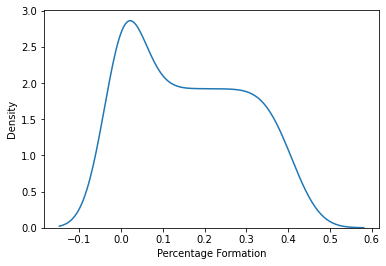

In [ ]:
sns.distplot(df["Percentage Formation"], hist=False)

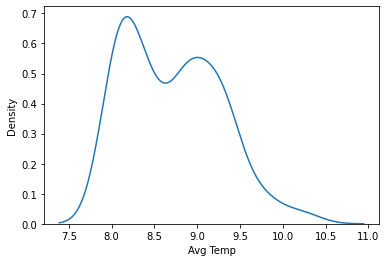

In [ ]:
sns.distplot(df["Avg Temp"], hist=False)


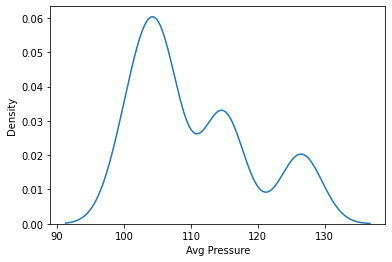

In [ ]:
sns.distplot(df["Avg Pressure"], hist=False)

UNivariate Analysis

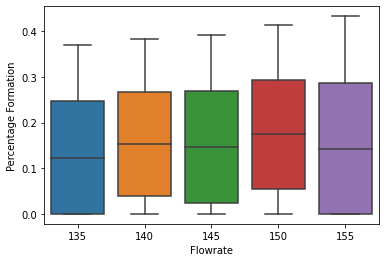

In [ ]:
sns.boxplot(x = df["Flowrate"], y= df['Percentage Formation'])

In [ ]:
# Perform Pearson correlation between all features  
def correl(data):
  pcorrs = data.corr()

  # Draw heat map
  fig = ff.create_annotated_heatmap(
      z=pcorrs.values,
      x=list(pcorrs.columns),
      y=list(pcorrs.index),
      annotation_text=pcorrs.round(2).values,
      showscale=True, colorscale='viridis')

  fig.update_layout(
      title="Correlation Matrix",
      width=1000,
      height =800,
      template='plotly_white',xaxis_tickangle=45
  )

  fig['layout']['xaxis']['side'] = 'bottom'

  fig.show()
correl(df)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            0 non-null      float64
 1   time                  156 non-null    int64  
 2   T1                    156 non-null    float64
 3   T2                    156 non-null    float64
 4   T3                    156 non-null    int64  
 5   P1(psi)               156 non-null    int64  
 6   P2(psi)               156 non-null    int64  
 7   P3(psi)               156 non-null    int64  
 8   P4(bar)               156 non-null    float64
 9   P5(psi)               156 non-null    int64  
 10  P6(psi)               156 non-null    int64  
 11  Hydrate               156 non-null    int64  
 12  Flowrate              156 non-null    int64  
 13  Percentage Formation  156 non-null    float64
 14  Volume                156 non-null    float64
 15  Avg Temp              1

In [ ]:
df.head()

,Unnamed: 0,time,T1,T2,T3,P1(psi),P2(psi),P3(psi),P4(bar),P5(psi),P6(psi),Hydrate,Flowrate,Percentage Formation,Volume,Avg Temp,Avg Pressure
0,NaN,0,24.0,30.0,34.0,150,170,150.0,0.411,150,150,0,145,0.0,0.0,29.333333,156.666667
1,NaN,2,24.0,26.0,33.0,120,138,120.0,0.4106,128,133,0,145,0.0,0.0,27.666667,126.000000
2,NaN,4,24.0,24.0,33.0,118,135,118.0,0.3958,125,130,0,145,0.0,0.0,27.000000,123.666667
3,NaN,6,23.0,19.0,32.0,118,132,118.0,0.3907,125,130,0,145,0.0,0.0,24.666667,122.666667
4,NaN,8,23.0,19.0,32.0,116,132,116.0,0.3731,125,129,0,145,0.0,0.0,24.666667,121.333333


In [ ]:
dfn = df.drop(['Unnamed: 0', 'T1', 'T2', 'T3', 'P1(psi)', 'P2(psi)', 'P3(psi)', 'Avg Pressure', 'P5(psi)', 'P6(psi)', 'Volume', 'Hydrate'],  axis = 1)

In [ ]:
dfn.head()

,time,P4(bar),Flowrate,Percentage Formation,Avg Temp
0,64,0.2871,135,0.0,10.333333
1,66,0.3090,135,0.0,10.166667
2,68,0.2965,135,0.0,10.166667
3,70,0.3050,135,0.0,9.833333
4,72,0.2997,135,0.0,9.833333


In [ ]:
dfs = dfn.sample(frac = 1)
dfs.head()

,time,P4(bar),Flowrate,Percentage Formation,Avg Temp
6,76,0.2951,135,0.000000,9.500000
99,90,0.3896,150,0.174731,9.000000
86,62,0.1827,150,0.000000,9.833333
66,88,0.3635,145,0.131000,8.166667
77,118,0.3546,145,0.376625,8.000000


In [ ]:
dfs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 156 entries, 6 to 105
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   time                  156 non-null    int64  
 1   P4(bar)               156 non-null    float64
 2   Flowrate              156 non-null    int64  
 3   Percentage Formation  156 non-null    float64
 4   Avg Temp              156 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 7.3 KB


In [ ]:
correl(dfs)

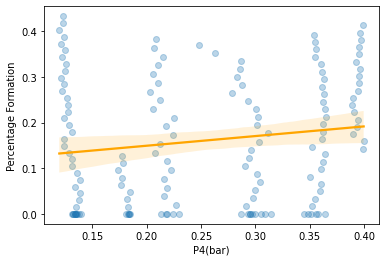

In [ ]:
sns.regplot(x=dfs['P4(bar)'], y=dfs['Percentage Formation'], scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})

In [ ]:
dfs.columns.tolist()

['time', 'P4(bar)', 'Flowrate', 'Percentage Formation', 'Avg Temp']

In [ ]:
dfsn = dfs[['time','Flowrate', 'Avg Temp', 'P4(bar)', 'Percentage Formation']]

In [ ]:
dfsn.columns.tolist()

['time', 'Flowrate', 'Avg Temp', 'P4(bar)', 'Percentage Formation']

In [ ]:
# The data is categorized into predictor and response features i.e. X,y respectively

X = dfsn.iloc[:,[0,1,2,3]].copy()
y = dfsn.iloc[:,[4]].copy()

# Splitting the data using a test size of 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

In [ ]:
X_train.head()

,time,Flowrate,Avg Temp,P4(bar)
95,72,150,9.333333,0.1820
151,106,155,8.000000,0.1256
37,92,140,8.833333,0.2183
53,100,140,8.500000,0.2182
122,70,155,8.833333,0.1344


In [ ]:
pip install ax

     |████████████████████████████████| 8.7 MB 16.9 MB/s 
     |████████████████████████████████| 107 kB 58.4 MB/s 
     |████████████████████████████████| 507 kB 52.4 MB/s 
     |████████████████████████████████| 123 kB 49.1 MB/s 
     |████████████████████████████████| 227 kB 60.8 MB/s 
     |████████████████████████████████| 6.0 MB 52.6 MB/s 
     |████████████████████████████████| 128 kB 45.7 MB/s 
     |████████████████████████████████| 77 kB 6.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.2 MB/s 
     |████████████████████████████████| 1.2 MB 38.6 MB/s 
     |████████████████████████████████| 250 kB 51.6 MB/s 
     |████████████████████████████████| 58 kB 6.8 MB/s 
     |████████████████████████████████| 1.1 MB 13.4 MB/s 
     |████████████████████████████████| 201 kB 48.7 MB/s 
     |████████████████████████████████| 72 kB 534 kB/s 
     |████████████████████████████████| 54 kB 2.6 MB/s 
     |████████████████████████████████| 71 kB 7.2 MB/s 
     |██████████████████

In [ ]:
import ax
from sklearn.linear_model import Ridge
from math import sqrt
from sklearn.metrics import mean_squared_error

In [ ]:
norm_scaler = MinMaxScaler()                 
nfeatures = norm_scaler.fit_transform(dfsn)          
df_n = pd.DataFrame(nfeatures,index=df.index)
df_n.columns = dfsn.columns.copy()
df_n.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,305.0,0.500000,0.293929,0.0,0.250000,0.500000,0.750000,1.0
Flowrate,305.0,0.500000,0.354134,0.0,0.250000,0.500000,0.750000,1.0
Avg Temp,305.0,0.179954,0.232732,0.0,0.029412,0.066176,0.235294,1.0
Avg Pressure,305.0,0.257426,0.203296,0.0,0.089286,0.250000,0.440476,1.0
Percentage Formation,305.0,0.189865,0.290340,0.0,0.000000,0.000000,0.353811,1.0


In [ ]:
sns.distplot(df_n["Percentage Formation"], hist=False)

In [ ]:
df_s

In [ ]:
stand_scaler = StandardScaler()                 
nfeatures = stand_scaler.fit_transform(dfsn)          
df_s = pd.DataFrame(nfeatures,index=df.index)
df_s.columns = dfsn.columns.copy()
df_s.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,156.0,1.964241e-16,1.003221,-2.426571,-0.775339,0.050278,0.875894,1.598309
Flowrate,156.0,1.901613e-15,1.003221,-1.505427,-0.814702,-0.123976,1.257475,1.257475
Avg Temp,156.0,-2.476651e-16,1.003221,-1.278059,-0.978694,0.069084,0.817497,2.913054
P4(bar),156.0,-3.843080e-16,1.003221,-1.383761,-1.182843,-0.154493,1.043011,1.505536
Percentage Formation,156.0,1.665335e-16,1.003221,-1.192163,-1.063790,-0.091906,0.879088,2.019396


In [ ]:
df_n

In [ ]:
Xnew = df_s.iloc[:,[0,1,2,3]].copy()
ynew = df_s.iloc[:,[4]].copy()

# Splitting the data using a test size of 0.25
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state = 42)

         time  Flowrate  Avg Temp   P4(bar)
15   0.669490  0.566749 -0.679329  1.451820
14   1.391905 -1.505427  0.518132  0.338247
103 -0.362530 -0.123976 -0.978694  1.000399
0   -0.672136 -1.505427  1.416228  0.428118
39   0.566288  1.257475 -1.278059 -1.338309
     Percentage Formation
15               0.810711
14               1.290765
103             -0.584897
0               -1.192163
39               0.911962
0.9375741271016865
Linear RMSE:  0.231953188587828


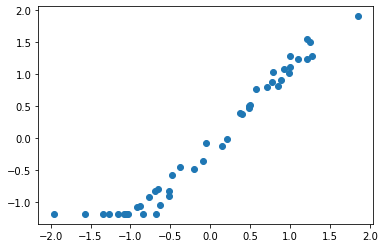

In [ ]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test = train_test_split(Xnew,ynew,test_size=0.3)
from sklearn.linear_model import LinearRegression
print(X_test.head())
print(y_test.head())
lr = LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
print(metrics.r2_score(pred,y_test))
plt.scatter(pred, y_test)
plt.show
pred
linear_rmsle = sqrt(mean_squared_error(y_test, pred))
print('Linear RMSE: ', linear_rmsle)

In [ ]:
X

,time,Flowrate,Avg Temp,Avg Pressure
286,84,150,9.333333,106.333333
150,56,140,9.833333,128.000000
25,50,145,9.833333,106.333333
277,66,150,9.333333,106.333333
103,84,135,9.333333,101.333333
...,...,...,...,...
71,20,135,24.666667,117.666667
6,12,145,21.000000,116.666667
273,58,150,10.166667,107.000000
207,48,155,9.166667,115.666667


100%|██████████| 13/13 [00:00<00:00, 199.23it/s]


RMSLE for alpha =  1 is 0.16816988984034292
RMSLE for alpha =  2 is 0.169556534387476
RMSLE for alpha =  3 is 0.1720684187337484
RMSLE for alpha =  3.5 is 0.17396589173993057
RMSLE for alpha =  4 is 0.1753072729011861
RMSLE for alpha =  4.5 is 0.17730060953977836
RMSLE for alpha =  5 is 0.17945552904302556
RMSLE for alpha =  6 is 0.18385534037097204
RMSLE for alpha =  7 is 0.18875040737731025
RMSLE for alpha =  8 is 0.19317782844875803
RMSLE for alpha =  9 is 0.19800012456623511
RMSLE for alpha =  10 is 0.20285297838325841
RMSLE for alpha =  12 is 0.21258829288361678


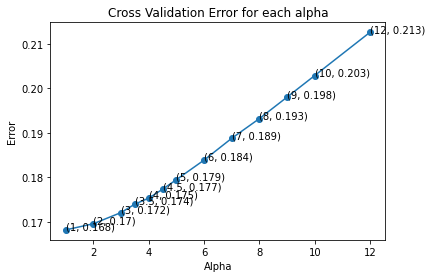

In [ ]:

alpha = [1, 2, 3, 3.5, 4, 4.5, 5, 6, 7,8,9,10,12] 
#alpha = list(range(1, 101))
cv_rmsle_array=[] 
for i in tqdm(alpha):
    model = Ridge(solver="sag", random_state=42, alpha=i)
    model.fit(X_train, y_train)
    preds_cv = model.predict(X_test)
    cv_rmsle_array.append(sqrt(mean_squared_error(y_test, preds_cv)))

for i in range(len(cv_rmsle_array)):
    print ('RMSLE for alpha = ',alpha[i],'is',cv_rmsle_array[i])
    
best_alpha = np.argmin(cv_rmsle_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_rmsle_array)
ax.scatter(alpha, cv_rmsle_array)
for i, txt in enumerate(np.round(cv_rmsle_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_rmsle_array[i]))

plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha")
plt.ylabel("Error")
plt.show()

Best alpha:  1
Train RMSLE: 0.22631966426951092
Cross validation RMSLE:  0.16816988984034292
0.9594582098166492


<function matplotlib.pyplot.show>

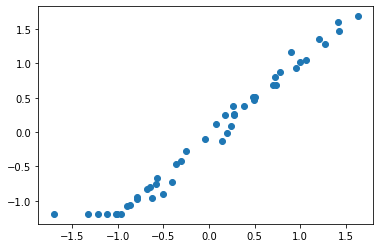

In [ ]:
print("Best alpha: ",  alpha[best_alpha])
model = Ridge(solver="sag", random_state=42, alpha=alpha[best_alpha])
model.fit(X_train, y_train)
ridge_preds_tr = model.predict(X_train)
ridge_preds_cv = model.predict(X_test)
ridge_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mean_squared_error(y_train, ridge_preds_tr)))

ridge_rmsle = sqrt(mean_squared_error(y_test, ridge_preds_cv))
print("Cross validation RMSLE: ", ridge_rmsle)
print(metrics.r2_score(ridge_preds_cv, y_test))
plt.scatter(ridge_preds_cv, y_test)
plt.show

In [ ]:
import lightgbm as ltb
import random
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
lgb_model = ltb.LGBMRegressor(subsample=0.9, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)

params = {'learning_rate': random.uniform(0, 1),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': random.uniform(0, 2),
          'colsample_bytree': random.uniform(0, 1),
         }
lgb_random = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)
lgb_random = lgb_model.fit(X_train, y_train)

#best_params = lgb_model.best_params_
#print(best_params)

Train RMSLE: 0.1993713158312405
Cross validation RMSLE:  0.23427680311729263
0.9354083276217331


<function matplotlib.pyplot.show>

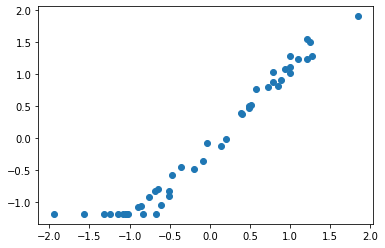

In [ ]:

lgb_preds_tr = model.predict(X_train)
lgb_preds_te = model.predict(X_test)

print('Train RMSLE:', sqrt(mean_squared_error(y_train, lgb_preds_tr)))

lgb_rmsle = sqrt(mean_squared_error(y_test, lgb_preds_te))
print("Cross validation RMSLE: ", lgb_rmsle)
print(metrics.r2_score(lgb_preds_te, y_test))
plt.scatter(lgb_preds_te, y_test)
plt.show